In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
from MyCode.utils import export_graphviz
import graphviz

pd.set_option('max_columns', None)

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [2]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [3]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [4]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']

In [5]:
def train_test_split(random_state):
    global X_train, y_train, sensitive_train
    global X_test, y_test, sensitive_test


    index_train = list(df.sample(frac=0.8, random_state=random_state).index)
    index_test = list(df.drop(index=index_train).index)

    X_train = X.drop(index=index_test).to_numpy()
    y_train = y.drop(index=index_test).to_numpy()
    sensitive_train = sensitive.drop(index=index_test).to_numpy()

    X_test = X.drop(index=index_train).to_numpy()
    y_test = list(y.drop(index=index_train).to_numpy())
    sensitive_test = sensitive.drop(index=index_train).to_numpy()
train_test_split(1)

In [6]:
def discrimination(sensitive, y):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, clf(𝑥) = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, clf(𝑥) = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1, n_zero, n_one= 0, 0, 0, 0
    for i in range(0, len(y)):
        if sensitive[i] == 0.0:
            n_zero+=1
            if y[i] == 1.0:
                p0+=1
        elif sensitive[i] == 1.0:
            n_one+=1
            if y[i] == 1.0:
                p1+=1

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def discr_add(tids):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, 𝑥.Class = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, 𝑥.Class = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1 = 0, 0
    for i in tids:
        if sensitive_train[i] == 0.0:
            if y_train[i] == 1.0:
                p0+=1
        elif sensitive_train[i] == 1.0:
            if y_train[i] == 1.0:
                p1+=1

    cnt = np.unique(sensitive_train, return_counts=True)[1]
    n_zero = cnt[0]
    n_one = cnt[1]

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def misclassified(tids):
    classes, supports = np.unique(y_train.take(tids), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex], classes[maxindex]

def error(tids, k=0):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def error1(tids, k=1):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def error2(tids, k=10):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def error3(tids, k=100):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def error4(tids, k=1000):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def tree_upgrade(tree):
    if 'feat' in tree:
        tree_upgrade(tree['left'])
        tree_upgrade(tree['right'])
    else:
        tree['discrimination_additive'] = discr_add(tree['transactions'])
        tree['misclassified'] = misclassified(tree['transactions'])[0]

In [7]:
result = pd.DataFrame(columns=['function', 'depth', "random_state", 'clf.error_', 'clf.accuracy_', 'accuracy_train', "accuracy_test", 'discrimination_train', 'discrimination_test', "duration", "min_supp", "tree"])

def xx(clf, function):
    print(f"### Depth: {depth} state: {random_state} {function} ###")
    start = time.perf_counter()
    print(f"Model building...")
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    print("Model built. Duration of building =", round(duration, 4))
    print("clf.accuracy_ =", round(clf.accuracy_, 4))
    y_pred_train = clf.predict(X_train)
    accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
    print("Accuracy DL8.5 on training set =", accuracy_train)
    y_pred_test = clf.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
    print("Accuracy DL8.5 on test set =", accuracy_test)
    discrimation_train = round(discrimination(sensitive_train, y_pred_train), 4)
    print("Discrimination of classifier on train", round(discrimination(sensitive_train, y_pred_train), 4))
    discrimation_test = round(discrimination(sensitive_test, y_pred_test), 4)
    print("Discrimination of classifier on test", round(discrimination(sensitive_test, y_pred_test), 4))
    print(f"error: {clf.error_}")

    tree_upgrade(clf.tree_)
    result.loc[len(result.index)] = [function, depth, random_state, clf.error_, clf.accuracy_, accuracy_train, accuracy_test, abs(discrimation_train), abs(discrimation_test), duration, min_supp, clf.tree_]

if True:
    result = pd.read_csv('save/lawsuit_k_supp2')
else:
    for depth in range(1, 8):
        #for min_supp in range(1, len(X_train), int(len(X_train)/4)):
        for min_supp in range(2,3):
            for random_state in range(1, 101, 2):
                if random_state in [17, 35, 43, 71, 91]:
                    continue
                train_test_split(random_state)

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error(list(tids)), min_sup=min_supp, time_limit=600)
                xx(clf, "error")
                print()

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error1(list(tids)), min_sup=min_supp, time_limit=600)
                xx(clf, "error1")
                print()

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error2(list(tids)), min_sup=min_supp, time_limit=600)
                xx(clf, "error2")
                print()

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error3(list(tids)), min_sup=min_supp, time_limit=600)
                xx(clf, "error3")
                print()

                clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error4(list(tids)), min_sup=min_supp, time_limit=600)
                xx(clf, "error4")
                print()

    result.to_csv('save/lawsuit_k_supp2', index=False)

In [8]:
result = result.sort_values(['function', 'depth', 'min_supp'])
result

,function,depth,random_state,clf.error_,clf.accuracy_,accuracy_train,accuracy_test,discrimination_train,discrimination_test,duration,min_supp,tree
0,error,1,1,51.000000,0.755981,0.7560,0.7308,0.1565,0.2667,0.013712,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
5,error,1,3,48.000000,0.770335,0.7703,0.6731,0.2345,0.0461,0.010353,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
10,error,1,5,49.000000,0.765550,0.7656,0.6923,0.1796,0.1726,0.010666,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
15,error,1,7,51.000000,0.755981,0.7560,0.7308,0.1858,0.1379,0.012021,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
20,error,1,9,54.000000,0.741627,0.7416,0.7885,0.1446,0.2974,0.013650,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1554,error4,7,89,342.990204,-0.641101,0.8852,0.9231,0.2943,0.2729,3.045919,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'feat..."
1559,error4,7,93,320.553711,-0.533750,0.8947,0.9231,0.2273,0.4216,3.081419,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'valu..."
1564,error4,7,95,372.778015,-0.783627,0.9091,0.8462,0.2733,0.1611,3.126789,2,"{'feat': 7, 'left': {'feat': 1, 'left': {'feat..."
1569,error4,7,97,360.635651,-0.725529,0.9139,0.8077,0.2426,0.2692,2.887787,2,"{'feat': 1, 'left': {'feat': 2, 'left': {'feat..."


# Mean of random_state

In [9]:
plt.rcParams['figure.figsize'] = [9, 6]
def print_plot_mean(x_axe, y_axe, r, s1, s2):
    plt.figure(figsize= (9, 6))
    #r = r.loc[r["min_supp"] == 1]
    style = ['solid', 'dotted', ':','-.', 'dashed']
    k_val = ['0', '1', '10','100', '1000']
    fig, ax = plt.subplots()
    for function in [ "error", "error1", "error2", "error3", "error4"]:
        x_values = list()
        y_values = list()

        for depth in r['depth'].unique():
            df1 = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            y_values.append(df1[y_axe].mean())

        plt.plot(r['depth'].unique(), y_values, label = "k="+k_val.pop(0), linestyle=style.pop(0))


    ax.set_xlabel(x_axe)
    ax.set_ylabel(y_axe)
    ax.legend()
    ax.set_ylim(s1, s2)
    plt.show()

<Figure size 648x432 with 0 Axes>

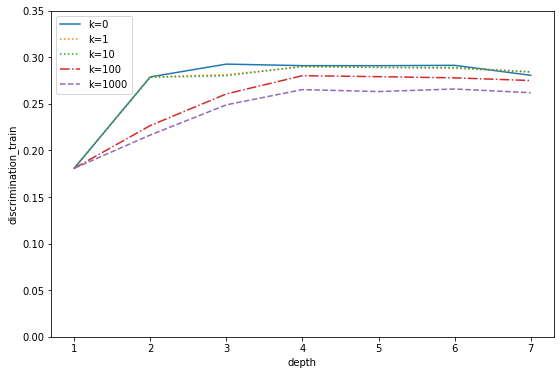

In [10]:
print_plot_mean("depth", "discrimination_train", result, 0, 0.35)

<Figure size 648x432 with 0 Axes>

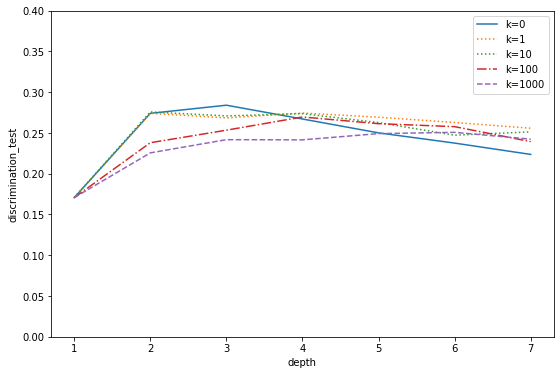

In [11]:
print_plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

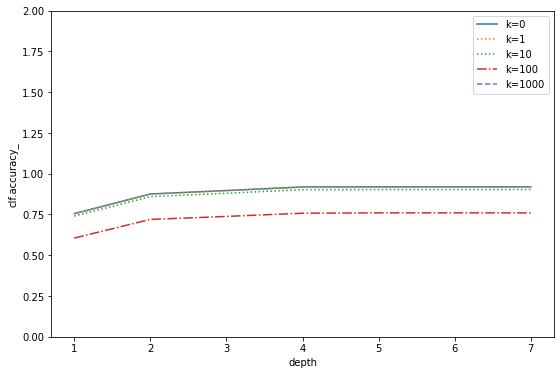

In [12]:
print_plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

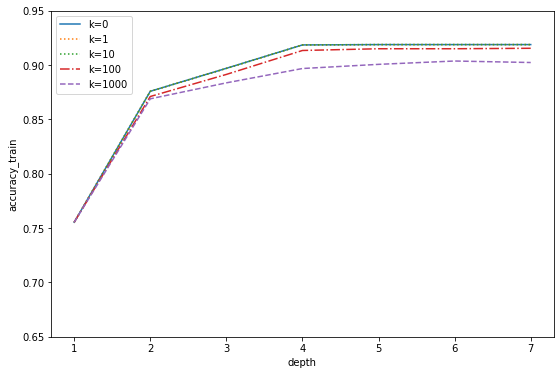

In [13]:
print_plot_mean("depth", "accuracy_train", result, 0.65, 0.95)

<Figure size 648x432 with 0 Axes>

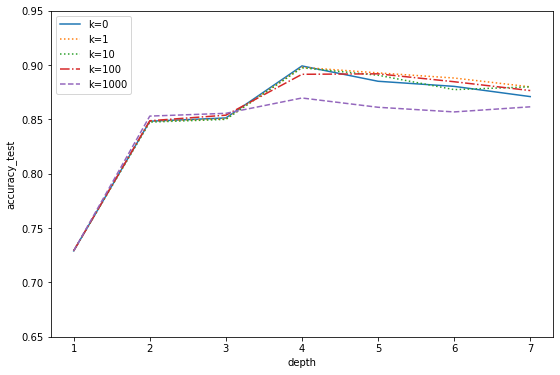

In [14]:
print_plot_mean("depth", "accuracy_test", result, 0.65, 0.95)

In [15]:
def print_plot(x_axe, y_axe, r):
    plt.figure(figsize= (9, 6))
    #r = r.loc[r["min_supp"] == 1]
    for function in ["error", "error1", "error2", "error3", "error4"]:
        x_values = list()
        y_values = list()

        for depth in r['depth'].unique():
            df1 = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            y_values.append(df1[y_axe].mean())
            x_values.append(df1[x_axe].mean())
        plt.plot(x_values, y_values, label = function)

    plt.xlabel(x_axe)
    plt.ylabel(y_axe)
    plt.legend()

    plt.show()

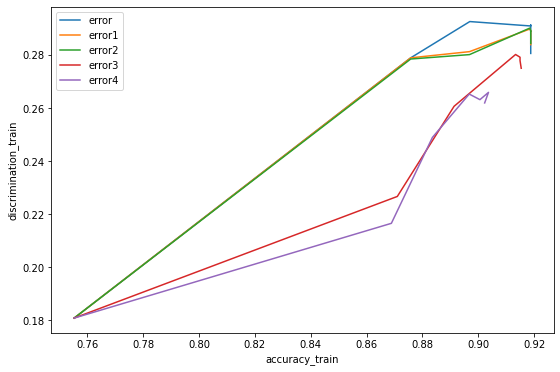

In [16]:
print_plot("accuracy_train", "discrimination_train", result)

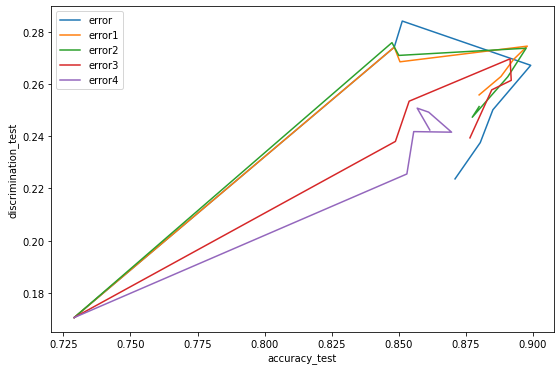

In [17]:
print_plot("accuracy_test", "discrimination_test", result)

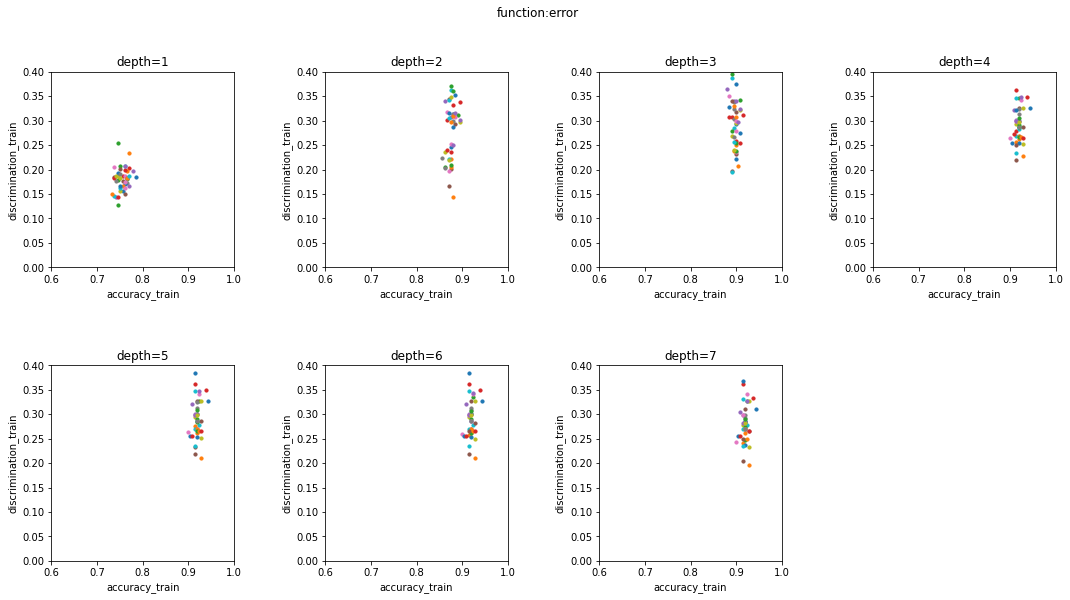

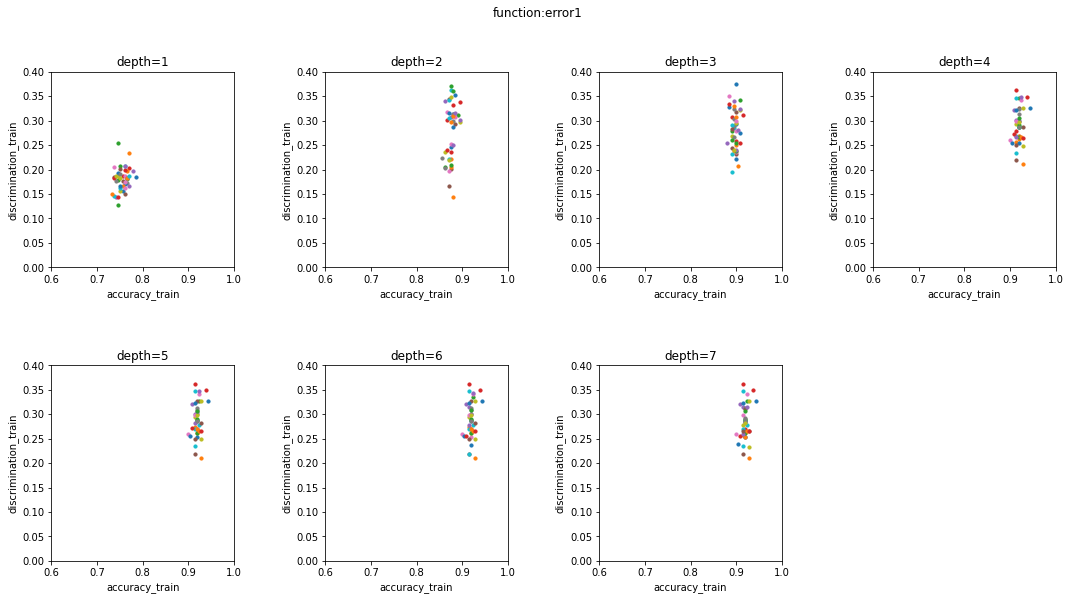

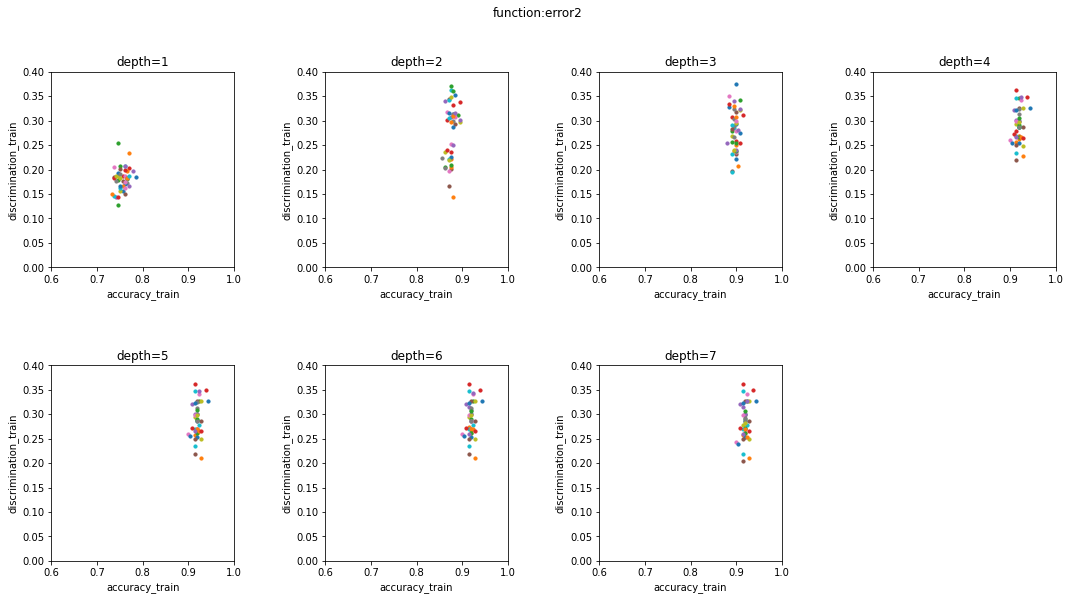

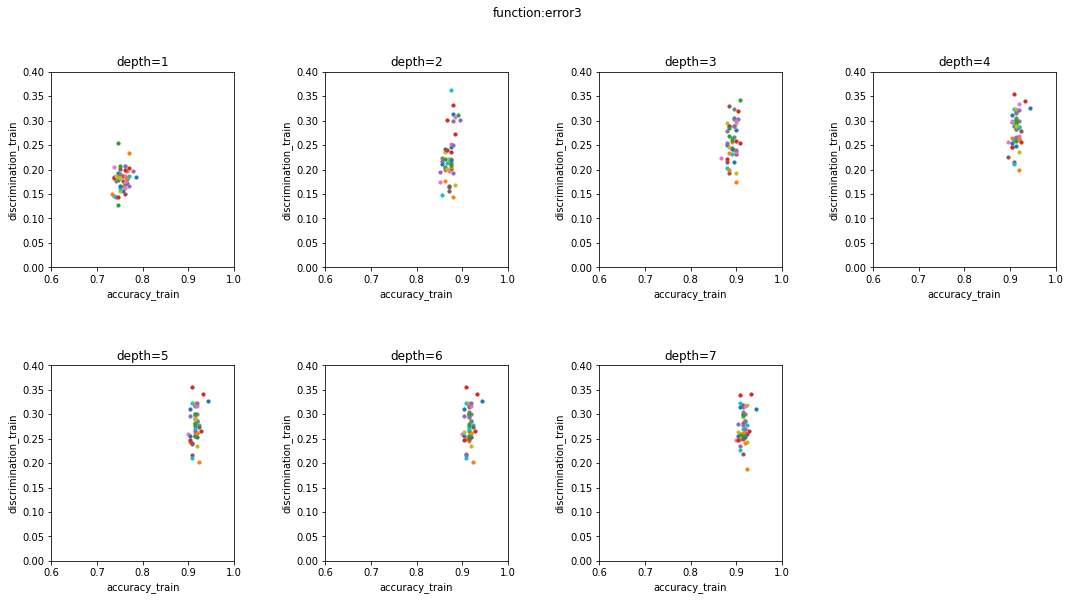

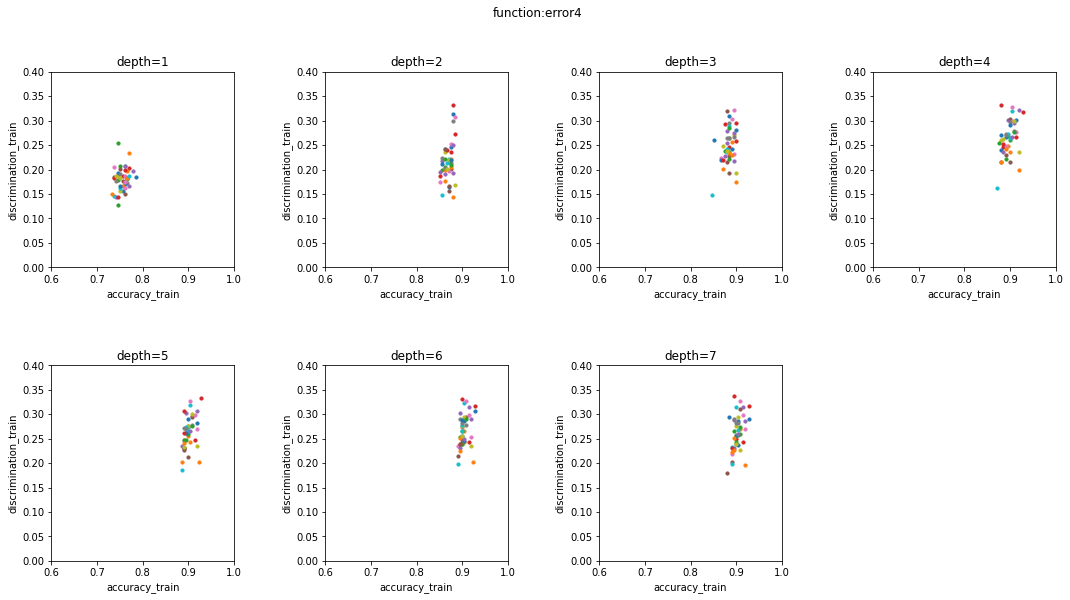

In [18]:
from matplotlib.pyplot import suptitle


def sss(x_axe, y_axe, r, x_lim, y_lim):
    #r = r.loc[r["min_supp"] == 1]
    for function in ["error", "error1", "error2", "error3", "error4"]:
        fig, axes= plt.subplots(nrows = 2, ncols = 4, figsize=(18, 9))
        for depth in r['depth'].unique():
            if depth > 4:
                ax = axes[1][depth-5]
            else:
                ax = axes[0][depth-1]
            rr = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            x = rr[x_axe].tolist()
            y = rr[y_axe].tolist()
            for i in range(0, len(x)):
                ax.set_ylim(y_lim[0], y_lim[1])
                ax.set_xlim(x_lim[0], x_lim[1])
                ax.scatter(x[i], y[i], s=10)
            ax.set_xlabel(x_axe)
            ax.set_ylabel(y_axe)
            ax.title.set_text('depth='+str(depth))
        fig.delaxes(axes[1][3])
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        suptitle('function:' +function)
        plt.show()
sss("accuracy_train", "discrimination_train", result, (0.6, 1), (0, 0.4),)

In [19]:
#sss("accuracy_test", "discrimination_test", result, (0, 0.4), (0.6, 1))

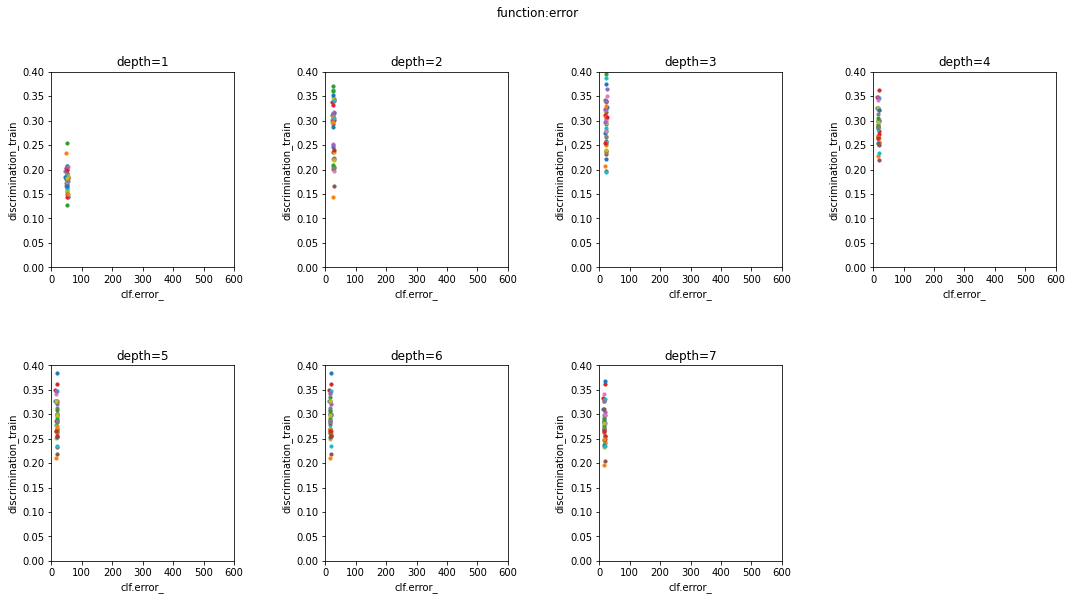

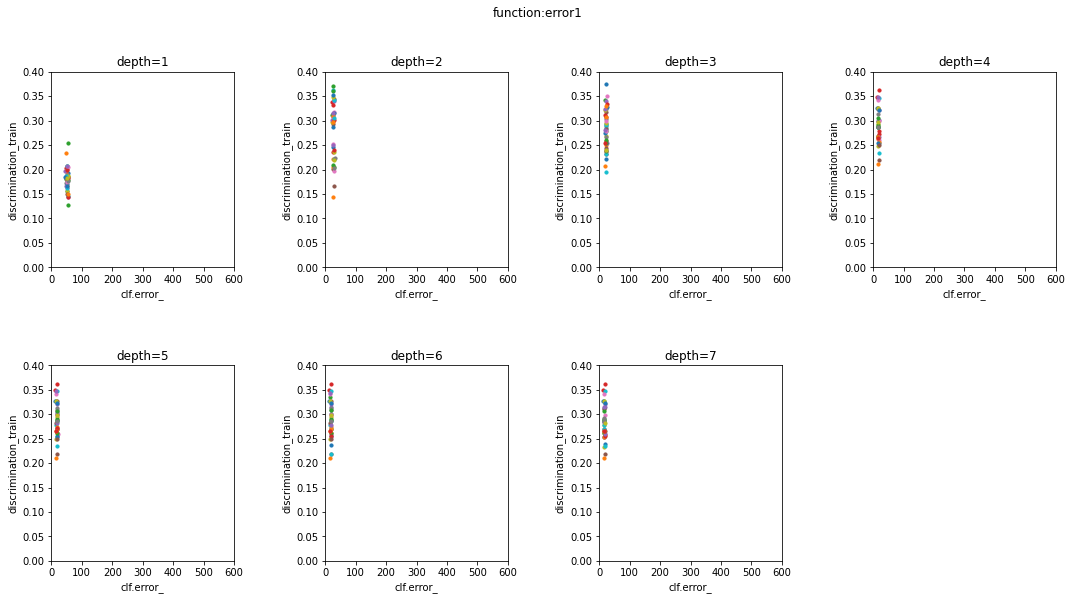

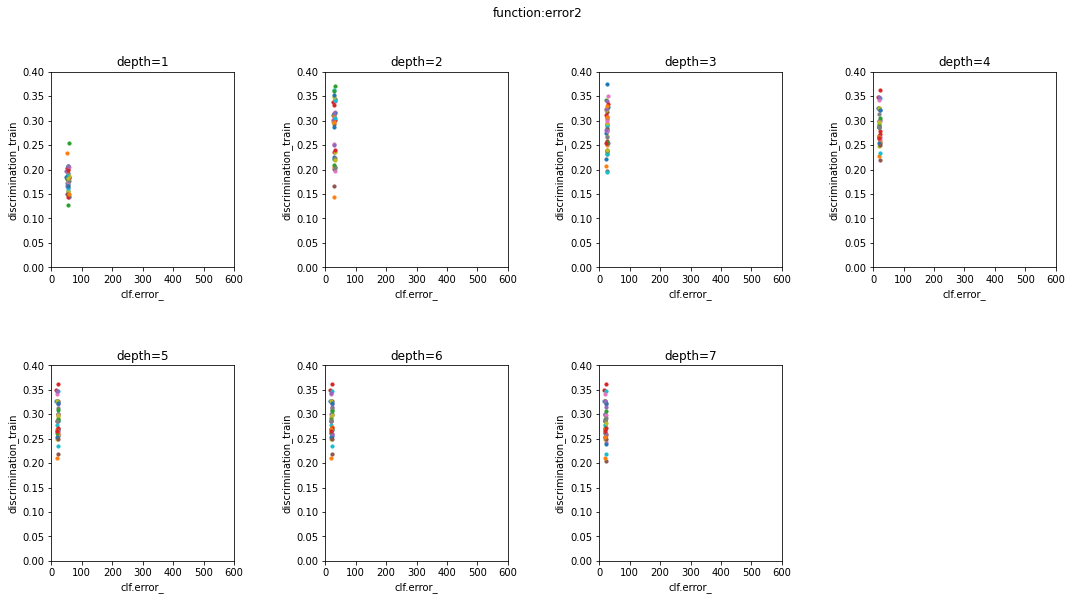

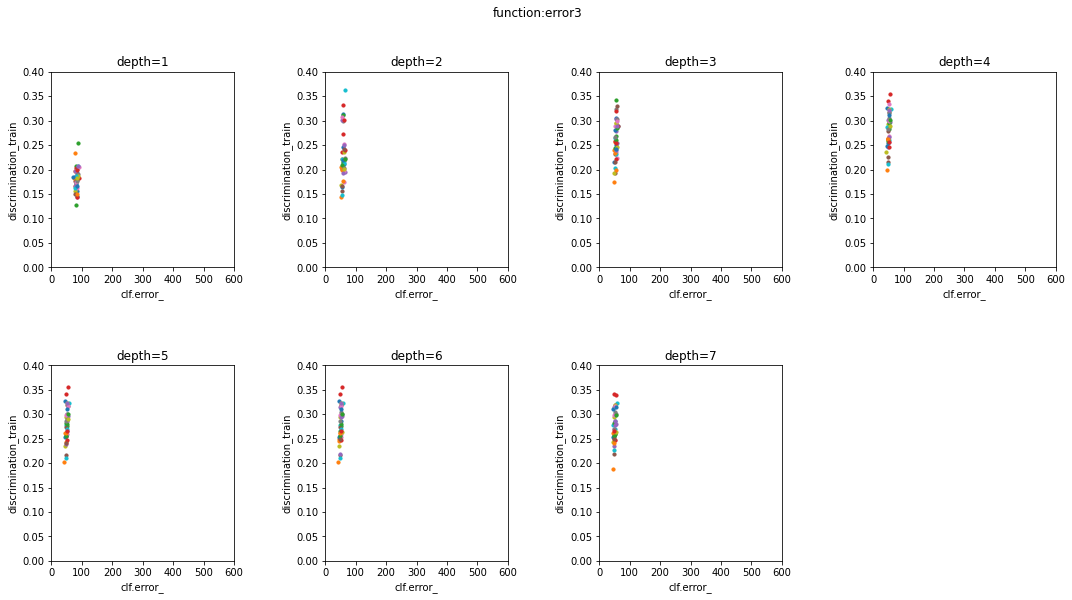

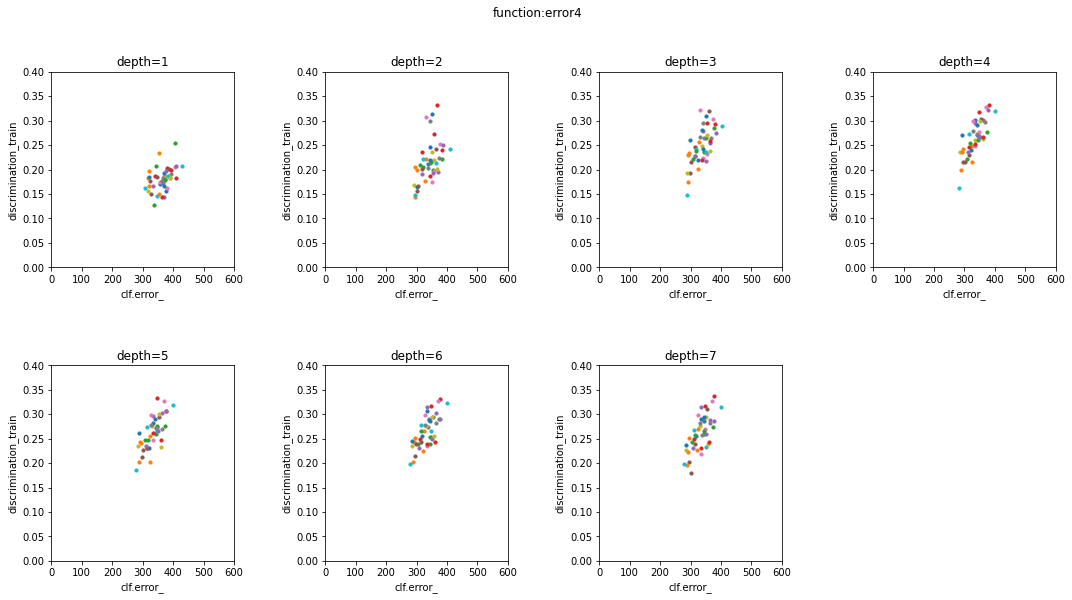

In [20]:
sss("clf.error_", "discrimination_train", result, (0, 600), (0, 0.4))

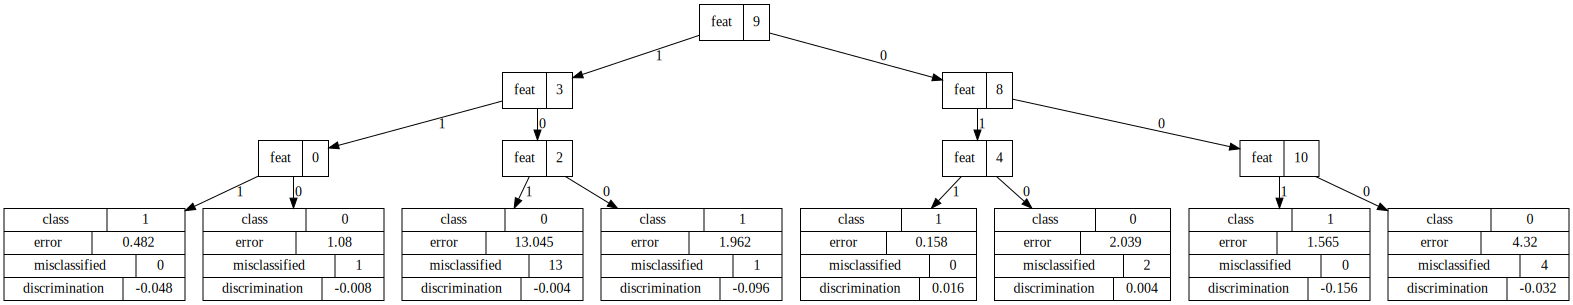

In [21]:
clf = DL85Classifier(max_depth=3, error_function=lambda tids: error2(list(tids)), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
tree_upgrade(clf.tree_)
dot = export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/lawsuit_k_supp2_tree")
graphviz.Source(dot)

In [22]:
def sum_elem_tree(tree, label, s=None, bool = True):
    if s is None:
        s = list()
    if 'feat' in tree:
        sum_elem_tree(tree['left'], label, s)
        sum_elem_tree(tree['right'], label, s)
    else:
        s.append(abs(tree[label]))
    if bool == False:
        return sum(s)
sum_elem_tree(clf.tree_, 'discrimination_additive', s=list(), bool=False)

0.36504761904761907

In [23]:
y_pred_train = clf.predict(X_train)
discrimation_train = discrimination(sensitive_train, y_train)
discrimation_train

-0.32561904761904764

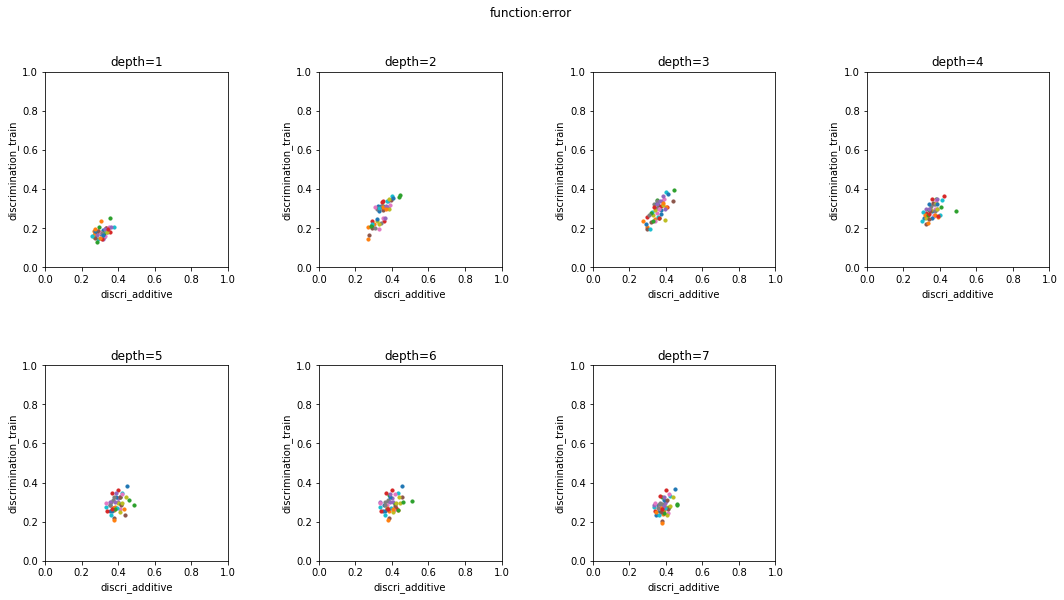

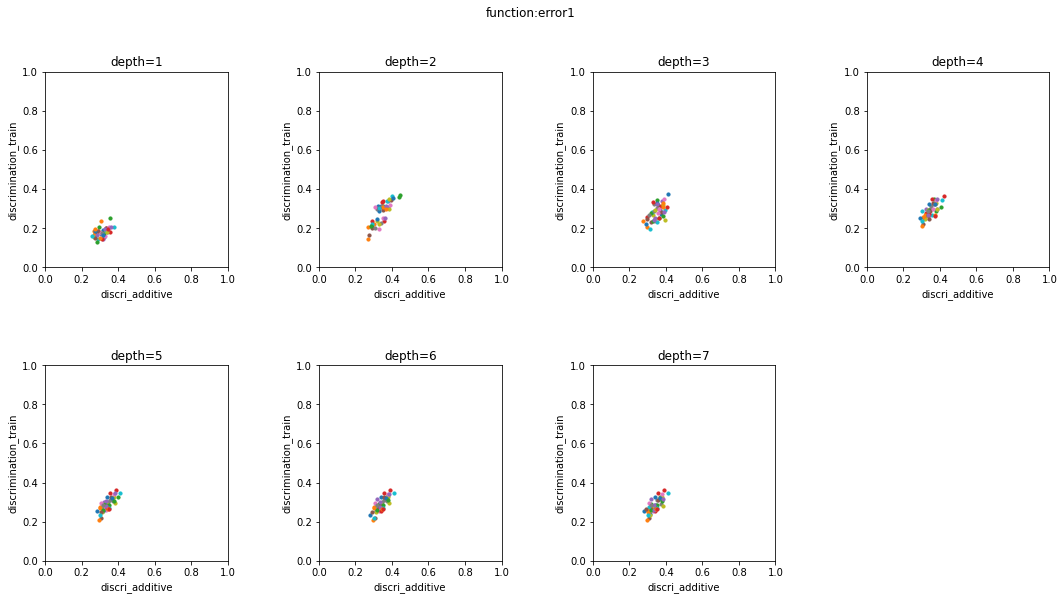

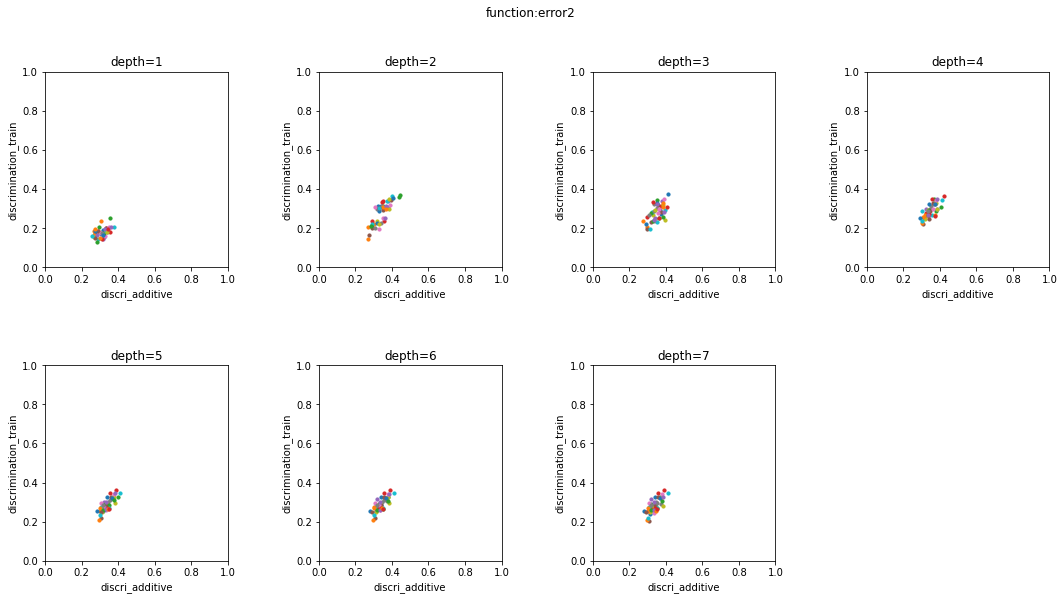

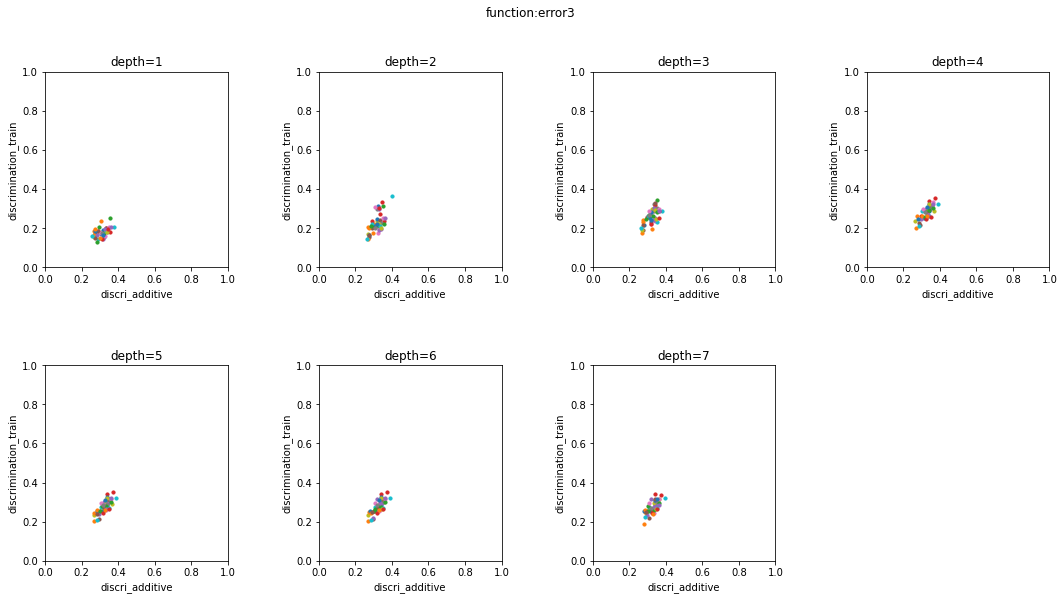

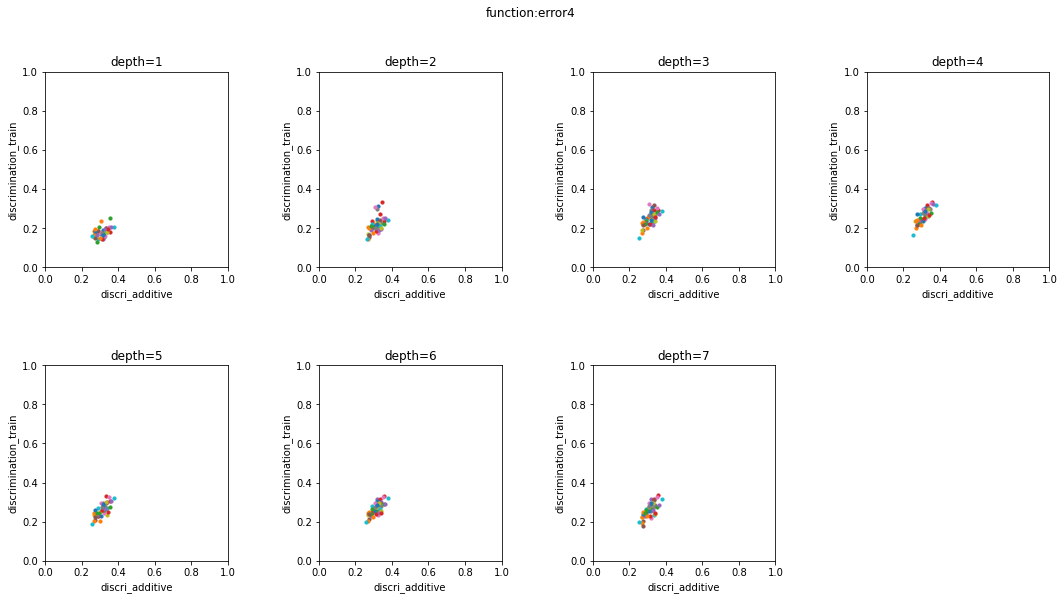

In [24]:
import ast
def ssss(y_axe, r, x_lim, y_lim):
    #r = r.loc[r["min_supp"] == 1]
    for function in ["error", "error1", "error2", "error3", "error4"]:
        fig, axes= plt.subplots(nrows = 2, ncols = 4, figsize=(18, 9))
        for depth in r['depth'].unique():
            if depth > 4:
                ax = axes[1][depth-5]
            else:
                ax = axes[0][depth-1]
            rr = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            x = list()
            for tree in rr["tree"]:
                x.append(sum_elem_tree(ast.literal_eval(tree), 'discrimination_additive', s=list(), bool=False))
            y = rr[y_axe].tolist()
            for i in range(0, len(x)):
                ax.set_ylim(y_lim[0], y_lim[1])
                ax.set_xlim(x_lim[0], x_lim[1])
                ax.scatter(x[i], y[i], s=10)
            ax.set_xlabel("discri_additive")
            ax.set_ylabel(y_axe)
            ax.title.set_text('depth='+str(depth))
        fig.delaxes(axes[1][3])
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        suptitle('function:' +function)
        plt.show()
ssss("discrimination_train", result, (0, 1), (0, 1),)